## A notebook to validate results from the mesh collisions API

- Get 2 more examples with no collisions visually by n collisions in API
- Make new notebook
- Share all TBs with more than 100% intersection

## Install and import libraries

In [25]:
%pip install requests pandas seaborn matplotlib.pyplot scipy.spatial.distance sklearn.metrics.pairwise hra_api_client

import requests
import pandas as pd
import seaborn as sns
import json
from pprint import pprint
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

import hra_api_client
from hra_api_client.api import v1_api as default_api
from hra_api_client.models.sparql_query_request import SparqlQueryRequest

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for matplotlib.pyplot


## Set global variables

In [26]:
# Get utilities.py
%run ../shared/utilities.py

In [27]:
# set hra-pop version
hra_pop_version = "v0.10.3"

## Load data


In [28]:
df_y = pd.read_csv(
  f"../../../hra-pop/output-data/{hra_pop_version}/reports/atlas/validation-v7-y-axis.csv")

## Investigate total intersection volume > 1.0

### Compute report with non-intersection volume per extraction site


See [https://github.com/x-atlas-consortia/hra-pop/issues/105](https://github.com/x-atlas-consortia/hra-pop/issues/105).
Need this format:
| extraction_site_id | total_intersection_percentage | number_of_AS_collisions | non_intersection_volume |
| --- | --- | --- | --- |
| IRI for extraction site | sum of percentages with all collision items | unique UBERON IDs/FMA IDs in mesh collisions| 1-total_intersection_percentage |


Get collision data for extraction site IRIs and get `organ`,	`total_intersection_percentage`,	`number_of_AS_collisions`,	`non_intersection_volume`

In [29]:
# initialize dict for result
result = {
  'iri' : [],
  'organ' : [],
  'colliding_as' : [],
  'total_intersection_percentage': [],
  'number_of_AS_collisions': [],
}

# get extraction site IRIs and then get AS intersections from HRA API
for iri in df_y['rui_location']:
  result['iri'].append(iri)
  collisions = get_as_collision_items(iri, get_organ=True)

  # fill result dicy
  keys = [key for key in collisions if key != 'organ']
  result['colliding_as'].append(keys)
  result['number_of_AS_collisions'].append(len(keys))
  
  # compute total intersection percentage
  total_percentage = 0
  for structure in collisions:
    if structure != 'organ':
      total_percentage += collisions[structure]
  result['total_intersection_percentage'].append(total_percentage)
  
  # add organ for visualization
  result['organ'].append(collisions['organ'])

Convert to DataFrame


In [30]:
df_intersections = pd.DataFrame(result)

df_intersections

,iri,organ,colliding_as,total_intersection_percentage,number_of_AS_collisions
0,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7...,http://purl.org/ccf/latest/ccf.owl#VHFHeart,[http://purl.obolibrary.org/obo/UBERON_0002084],0.914,1
1,http://purl.org/ccf/1.5/8f99a469-7d51-46dc-919...,http://purl.org/ccf/latest/ccf.owl#VHFLeftKidn...,[http://purl.obolibrary.org/obo/UBERON_0004200],1.000,1
2,http://purl.org/ccf/1.5/f6512db4-2809-4ffe-864...,http://purl.org/ccf/latest/ccf.owl#VHMHeart,[http://purl.obolibrary.org/obo/UBERON_0002078],0.402,1
3,http://purl.org/ccf/1.5/886e391d-0151-46d3-8a5...,http://purl.org/ccf/latest/ccf.owl#VHMHeart,[http://purl.obolibrary.org/obo/UBERON_0002084],0.886,1
4,http://purl.org/ccf/1.5/da28394d-789a-4fba-842...,http://purl.org/ccf/latest/ccf.owl#VHMHeart,[http://purl.obolibrary.org/obo/UBERON_0002084],0.886,1
...,...,...,...,...,...
927,http://purl.org/ccf/1.5/aba1ebe3-af18-40cc-b53...,http://purl.org/ccf/latest/ccf.owl#VHMLung,[http://purl.org/sig/ont/fma/fma7361],1.000,1
928,http://purl.org/ccf/1.5/ca23f77c-a3cd-453f-bbe...,http://purl.org/ccf/latest/ccf.owl#VHMRightUreter,[http://purl.obolibrary.org/obo/UBERON_0001222],0.017,1
929,http://purl.org/ccf/1.5/d662fd53-e925-4921-8d8...,http://purl.org/ccf/latest/ccf.owl#VHMLung,[http://purl.org/sig/ont/fma/fma7360],0.995,1
930,http://purl.org/ccf/1.5/df0b33f7-371a-47a4-a63...,http://purl.org/ccf/latest/ccf.owl#VHMRightKidney,[http://purl.obolibrary.org/obo/UBERON_0002189...,1.000,2


Visualize

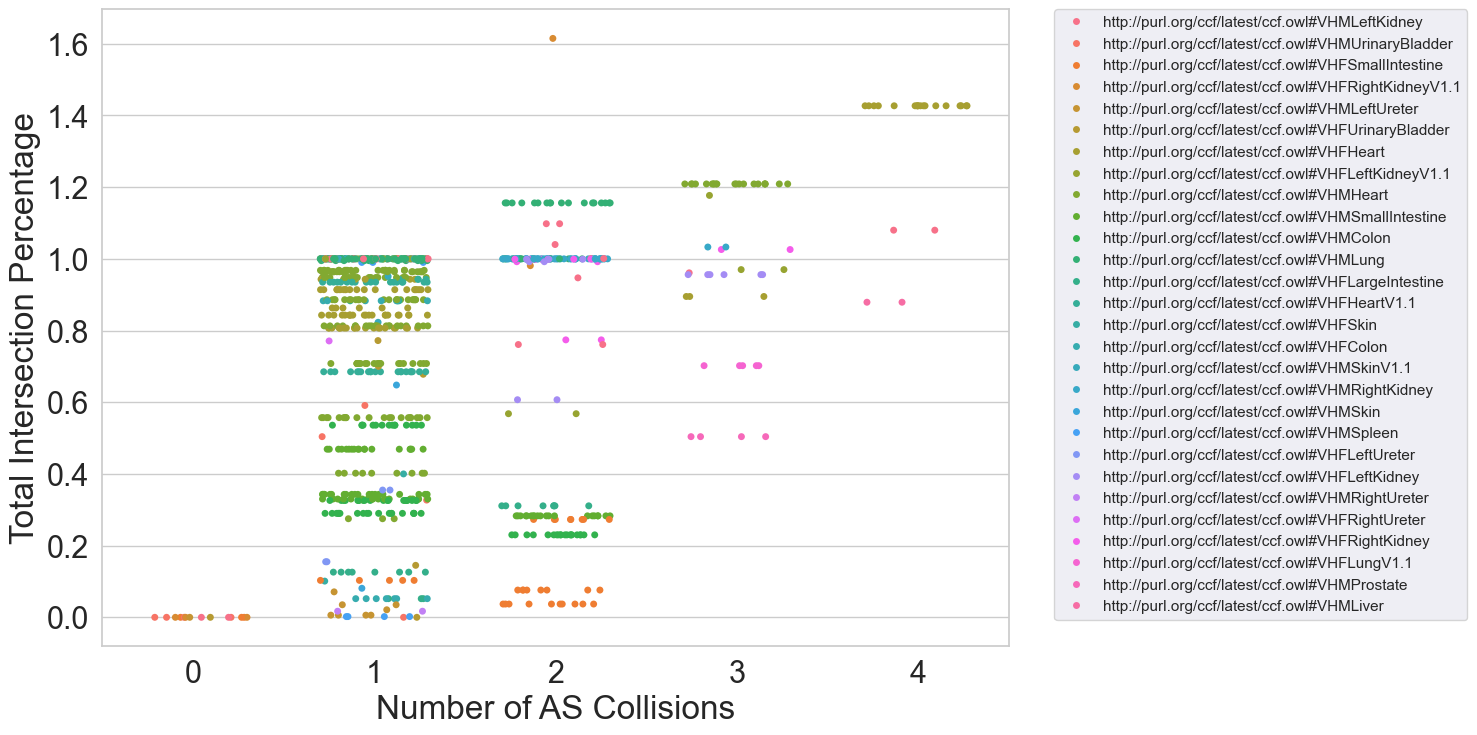

In [31]:
# Create a custom color palette
custom_palette = sns.color_palette("Dark2")

# define strip plot
g = sns.stripplot(data=df_intersections, x='number_of_AS_collisions',
                y='total_intersection_percentage', hue='organ', jitter=0.3)

# Set the style of the plot
# Options: "white", "dark", "whitegrid", "darkgrid", "ticks"
sns.set_style("whitegrid")

# change width
sns.set_theme(rc={'figure.figsize': (11.7, 8.27)})

# Set labels
g.set(xlabel="Number of AS Collisions", ylabel="Total Intersection Percentage")

# Move legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Show the plot
plt.show()

With facet

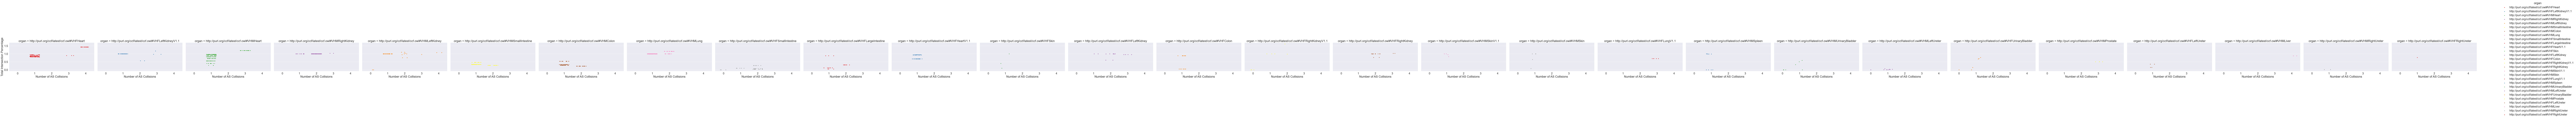

In [32]:
# Create a custom color palette
custom_palette = sns.color_palette("Set1")

# set font size
sns.set_theme(font_scale=2)

# Get order
categories_order = sorted(df_intersections['number_of_AS_collisions'].unique())

# Create FacetGrid
g = sns.FacetGrid(
    df_intersections,
    col='organ',
    hue='organ',
    palette=custom_palette,
    height=5,
    aspect=2
)

# Set the style of the plot
# Options: "white", "dark", "whitegrid", "darkgrid", "ticks"
sns.set_style("whitegrid")

# Create a scatter plot
g.map(sns.stripplot, 'number_of_AS_collisions',
      'total_intersection_percentage', jitter=0.3, order = categories_order)

# Set labels
g.set(xlabel="Number of AS Collisions", ylabel="Total Intersection Percentage")

# Add a legend
g.add_legend()

# Show the plot
plt.show()

## Follow the outliers

### Highest total intersection percentage

In [33]:
# get row with biggest total intersection percentage
max_row = df_intersections.loc[[df_intersections['total_intersection_percentage'].idxmax()]]
max_row



,iri,organ,colliding_as,total_intersection_percentage,number_of_AS_collisions
126,http://purl.org/ccf/1.5/4ae53bc8-b6da-4ba9-903...,http://purl.org/ccf/latest/ccf.owl#VHFRightKid...,[http://purl.obolibrary.org/obo/UBERON_0008716...,1.615,2


In [34]:
# get collisions for outlier extraction site
get_as_collision_items(
    max_row.iloc[0]['iri'])

{'http://purl.obolibrary.org/obo/UBERON_0008716': 0.796,
 'http://purl.obolibrary.org/obo/UBERON_0001284': 0.819}

The extraction site with IRI `http://purl.org/ccf/1.5/4ae53bc8-b6da-4ba9-9030-a93ae44389b9` intersects with
- [http://purl.obolibrary.org/obo/UBERON_0008716](http://purl.obolibrary.org/obo/UBERON_0008716), hilum of kidney, 0.796
- [http://purl.obolibrary.org/obo/UBERON_0001284](http://purl.obolibrary.org/obo/UBERON_0001284), renal column, 0.819

The collisions endpoint returns:
```json
[
  {
    "AS_volume": -3315.9891939667878,
    "id": "https://purl.humanatlas.io/ref-organ/kidney-female-right/v1.3#VH_F_hilum_of_kidney_R",
    "intersection_volume": 14.328000000000001,
    "is_closed": true,
    "label": "hilum of kidney",
    "node_name": "VH_F_hilum_of_kidney_R",
    "organ": "https___cdn.humanatlas.io_digital-objects_ref-organ_kidney-female-right_v1.3_assets_3d-vh-f-kidney-r",
    "percentage_of_AS": -0.004320882596984575,
    "percentage_of_tissue_block": 0.796,
    "representation_of": "http://purl.obolibrary.org/obo/UBERON_0008716",
    "tissue_volume": 18
  },
  {
    "AS_volume": 52517.21248501704,
    "id": "https://purl.humanatlas.io/ref-organ/kidney-female-right/v1.3#VH_F_renal_column_R",
    "intersection_volume": 14.741999999999999,
    "is_closed": true,
    "label": "renal column",
    "node_name": "VH_F_renal_column_R",
    "organ": "https___cdn.humanatlas.io_digital-objects_ref-organ_kidney-female-right_v1.3_assets_3d-vh-f-kidney-r",
    "percentage_of_AS": 0.000280707967967756,
    "percentage_of_tissue_block": 0.819,
    "representation_of": "http://purl.obolibrary.org/obo/UBERON_0001284",
    "tissue_volume": 18
  }
]
```

It has the following location:

![](data/outlier_extraction_site.png)

### All > 1.0

In [35]:
greather_than_1 = df_intersections[df_intersections['total_intersection_percentage'] > 1.0]

# inspect dataframe
greather_than_1

,iri,organ,colliding_as,total_intersection_percentage,number_of_AS_collisions
21,http://purl.org/ccf/1.5/05c11830-1526-4472-bd1...,http://purl.org/ccf/latest/ccf.owl#VHFHeart,"[http://purl.org/sig/ont/fma/fma7267, http://p...",1.427,4
27,http://purl.org/ccf/1.5/da60f474-614a-4e0a-adb...,http://purl.org/ccf/latest/ccf.owl#VHMLung,"[http://purl.org/sig/ont/fma/fma7402, http://p...",1.156,2
32,http://purl.org/ccf/1.5/da60f474-614a-4e0a-adb...,http://purl.org/ccf/latest/ccf.owl#VHMLung,"[http://purl.org/sig/ont/fma/fma7402, http://p...",1.156,2
56,http://purl.org/ccf/1.5/da60f474-614a-4e0a-adb...,http://purl.org/ccf/latest/ccf.owl#VHMLung,"[http://purl.org/sig/ont/fma/fma7402, http://p...",1.156,2
75,http://purl.org/ccf/1.5/da60f474-614a-4e0a-adb...,http://purl.org/ccf/latest/ccf.owl#VHMLung,"[http://purl.org/sig/ont/fma/fma7402, http://p...",1.156,2
...,...,...,...,...,...
831,http://purl.org/ccf/1.5/c07ec91d-9dbe-4132-a93...,http://purl.org/ccf/latest/ccf.owl#VHMLeftKidney,[http://purl.obolibrary.org/obo/UBERON_0002189...,1.098,2
832,http://purl.org/ccf/1.5/05c11830-1526-4472-bd1...,http://purl.org/ccf/latest/ccf.owl#VHFHeart,"[http://purl.org/sig/ont/fma/fma7267, http://p...",1.427,4
866,http://purl.org/ccf/1.5/1d965182-bf13-4738-af0...,http://purl.org/ccf/latest/ccf.owl#VHFRightKidney,[http://purl.obolibrary.org/obo/UBERON_0002189...,1.026,3
882,http://purl.org/ccf/1.5/cf4ba102-edf7-4fe4-bb1...,http://purl.org/ccf/latest/ccf.owl#VHMLeftKidney,[http://purl.obolibrary.org/obo/UBERON_0002189...,1.080,4


In [36]:
print(f'Number of unique extraction sites with total intersection percentage > 1.0: {len(greather_than_1['iri'].unique())}')

print(f'Number of datasets with total intersection percentage > 1.0: {
      len(greather_than_1)}')

Number of unique extraction sites with total intersection percentage > 1.0: 11
Number of datasets with total intersection percentage > 1.0: 70


In [37]:
# list IRIs for those extraction sites
greather_than_1['iri'].unique()

array(['http://purl.org/ccf/1.5/05c11830-1526-4472-bd12-ea24dbcfd3cc',
       'http://purl.org/ccf/1.5/da60f474-614a-4e0a-adbe-521ba44c7bf0',
       'http://purl.org/ccf/1.5/57bab703-98bd-4106-9160-af951a74e4df',
       'http://purl.org/ccf/1.5/fdb0d1f7-94d5-4628-b345-dbe4975966fd',
       'http://purl.org/ccf/1.5/4ae53bc8-b6da-4ba9-9030-a93ae44389b9',
       'http://purl.org/ccf/1.5/7f7fe1b0-d9f6-48c2-a304-2ea5874c7392',
       'http://purl.org/ccf/1.5/cf4ba102-edf7-4fe4-bb1d-860cdf57609d',
       'http://purl.org/ccf/1.5/c07ec91d-9dbe-4132-a93c-b960895b009d',
       'http://purl.org/ccf/1.5/f3f2fabb-6802-4fd4-920e-1914293db252',
       'http://purl.org/ccf/1.5/1d965182-bf13-4738-af05-72b817121959',
       'http://purl.org/ccf/1.5/70ad7ae6-c9af-4975-98e2-98c249e36ddd'],
      dtype=object)

###Example: `http://purl.org/ccf/1.5/7f7fe1b0-d9f6-48c2-a304-2ea5874c7392`

![](data/7f7fe1b0-d9f6-48c2-a304-2ea5874c7392.png)
![](data/7f7fe1b0-d9f6-48c2-a304-2ea5874c7392_2.png)

### Exploring OFF for hilum in MeshLab

Notes:
- Left: original HRA v2.1 hilum of the female, right kidney
- Right: OFF version from [https://cdn.humanatlas.io/hra-glb-off-releases/hra-glb-off.v2.1.zip](https://cdn.humanatlas.io/hra-glb-off-releases/hra-glb-off.v2.1.zip)
- Different number of vertices and faces
- Misplaced vertex? 

![](data/mesh_lab.png)

In [38]:
# get AS collisions
get_as_collision_items(
    "http://purl.org/ccf/1.5/7f7fe1b0-d9f6-48c2-a304-2ea5874c7392")

{'http://purl.obolibrary.org/obo/UBERON_0002189': 0.04,
 'http://purl.obolibrary.org/obo/UBERON_0004200': 1}

## Check for AS-AS collisions

In [39]:
query = '''
PREFIX cc: <http://creativecommons.org/ns#>
#+ summary: Table S2
#+ description: Anatomical Structures in HRA, their volume, and predicted CT populations

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX ASCTB-TEMP: <https://purl.org/ccf/ASCTB-TEMP_>
PREFIX CL: <http://purl.obolibrary.org/obo/CL_>
PREFIX FMA: <http://purl.org/sig/ont/fma/fma>
PREFIX UBERON: <http://purl.obolibrary.org/obo/UBERON_>
PREFIX ccf: <http://purl.org/ccf/>
PREFIX CCF: <https://purl.humanatlas.io/graph/ccf>
PREFIX HRApop: <https://purl.humanatlas.io/graph/hra-pop>
PREFIX hra-pop: <https://purl.humanatlas.io/graph/hra-pop#>
PREFIX dc: <http://purl.org/dc/terms/>
PREFIX hubmap: <https://entity.api.hubmapconsortium.org/entities/>
PREFIX rui: <http://purl.org/ccf/1.5/>

SELECT DISTINCT ?organ ?organ_id ?as_label ?as_3d_id ?scene_node ?as_volume 
FROM HRApop:
FROM CCF:
WHERE {
  {
    SELECT ?organ ?as_label (SAMPLE(?as_3d_id) as ?as_3d_id) (SAMPLE(?scene_node) as ?scene_node) (AVG(?as_volume) as ?as_volume)
    WHERE {
      ?rui_location a ccf:SpatialEntity .
      ?rui_location ccf:has_collision_summary [
          ccf:has_collision_item [
            ccf:as_id ?as_id ;
            ccf:as_label ?as_label ;
            ccf:as_volume ?as_volume ;
			ccf:as_3d_id ?as_3d_id ;
            ccf:has_reference_organ ?ref_organ ;
          ]
      ] .
      ?as_3d_id ccf:has_object_reference [
      	ccf:file_subpath ?scene_node ;
      ] .
      BIND (REPLACE(REPLACE(REPLACE(STR(?ref_organ), "http://purl.org/ccf/latest/ccf.owl#", ""), "Colon", "LargeIntestine"), "V1.1", "") as ?organ)
    }
    GROUP BY ?organ ?as_label
  }

  {
    SELECT ?organ ?organ_id
    WHERE {
      ?ref_organ ccf:representation_of ?organ_iri .

      BIND (REPLACE(REPLACE(STR(?organ_iri), 'http://purl.obolibrary.org/obo/UBERON_', 'UBERON:'), 'http://purl.org/sig/ont/fma/fma', 'FMA:') as ?organ_id)
      BIND (REPLACE(REPLACE(REPLACE(STR(?ref_organ), "http://purl.org/ccf/latest/ccf.owl#", ""), "Colon", "LargeIntestine"), "V1.1", "") as ?organ)
    }
  }
  

}
ORDER BY ?organ ?as_label

'''

In [40]:
request = {"query": query}
# use only application/json in format, any other formats will result in errors.
try:
    # help(api_instance.sparql_post)
    api_response = api_instance.sparql_post(
        sparql_query_request=request, format='application/json')
    pprint(api_response)
except hra_api_client.ApiException as e:
    print("Exception when calling DefaultApi->sparql_post: %s\n" % e)

{'head': {'vars': ['organ',
                   'organ_id',
                   'as_label',
                   'as_3d_id',
                   'scene_node',
                   'as_volume']},
 'results': {'bindings': [{'as_3d_id': {'type': 'uri',
                                        'value': 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_papillary_muscle_of_heart_posmed'},
                           'as_label': {'datatype': 'http://www.w3.org/2001/XMLSchema#string',
                                        'type': 'literal',
                                        'value': 'Posteromedial head of '
                                                 'posterior papillary muscle '
                                                 'of left ventricle'},
                           'as_volume': {'datatype': 'http://www.w3.org/2001/XMLSchema#double',
                                         'type': 'literal',
                                         'value': '4401.499'},
                   

In [41]:
# get as_3d_id

unique_as_3d_id_hra_pop = set()

for item in api_response['results']['bindings']:
  unique_as_3d_id_hra_pop.add(item['as_3d_id']['value'])
  
pprint(unique_as_3d_id_hra_pop)

{'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_ascending_colon',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_caecum',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_descending_colon',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_diaphragmatic_surface_of_spleen',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_duodenum_ascending',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_duodenum_descending',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_duodenum_horizontal',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_duodenum_superior',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_fat_R',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_fundus_of_urinary_bladder_base',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_hilum_of_kidney_L',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_hilum_of_spleen',
 'http://purl.org/ccf/latest/ccf.owl#VHFemaleOrgans_VH_F_ileum',
 'http:

In [42]:
# load CSV from https://github.com/hubmapconsortium/hra-glb-mesh-collisions

as_as_collisions = pd.read_csv("data/collision_results.csv")
# pprint(as_as_collisions)

df_as_mesh = pd.DataFrame(as_as_collisions)

df_as_mesh


# Initialize a list to store results
check_result = []

# Apply a lambda function that checks if any substring in the set is part of the value
df_as_mesh['in_hra_pop'] = df_as_mesh['source'].apply(
    lambda x: any(substring in x for substring in unique_as_3d_id_hra_pop))

df_as_mesh

df_as_mesh.to_csv("output/df_as_mesh.csv")